In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
zip_path = '/content/drive/My Drive/data.zip'


In [5]:
import zipfile

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extract to /content directory in Colab


In [6]:

# Path to the extracted "data" directory
data_path = '/content/data'

# Paths to the extracted "normal" and "tumor" directories
normal_path = os.path.join(data_path, 'normal')
tumor_path = os.path.join(data_path, 'tumor')

# Check if the directories exist
print("Normal directory exists:", os.path.isdir(normal_path))
print("Tumor directory exists:", os.path.isdir(tumor_path))


Normal directory exists: True
Tumor directory exists: True


In [7]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

Current working directory: /content


In [8]:
# Check if directories exist
print("Normal directory exists:", os.path.isdir(normal_path))
print("Tumor directory exists:", os.path.isdir(tumor_path))

Normal directory exists: True
Tumor directory exists: True


In [9]:
import glob
# Load the list of filenames from the directories using glob
normal_filenames = glob.glob(os.path.join(normal_path, '*.jpg'))  # Adjust the file extension if needed
tumor_filenames = glob.glob(os.path.join(tumor_path, '*.jpg'))    # Adjust the file extension if needed


In [10]:
len(normal_filenames)

5077

In [11]:
len(tumor_filenames)

2283

In [12]:
# Combine the filenames and create labels
filenames = normal_filenames + tumor_filenames
labels = ['normal'] * len(normal_filenames) + ['tumor'] * len(tumor_filenames)

In [13]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42, stratify=labels)

In [18]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# For training data, use 'subset='training''
train_generator = train_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specify 'training' subset for training data
)

# For validation data, use 'subset='validation'' and same 'train_datagen' as used for training
validation_generator = train_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' subset for validation data
)

# For testing data, use separate 'test_datagen'
test_generator = test_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)



Found 5889 images belonging to 2 classes.
Found 1471 images belonging to 2 classes.
Found 7360 images belonging to 2 classes.


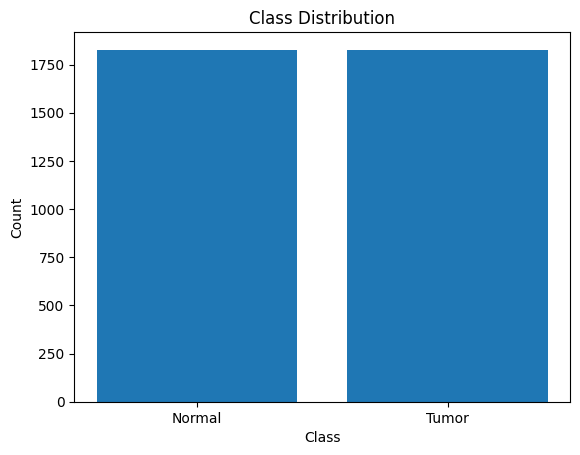

In [24]:
import matplotlib.pyplot as plt

# Count the number of images in each class
class_counts = train_generator.classes.sum(axis=0)

# Plot the class distribution
plt.bar(['Normal', 'Tumor'], class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


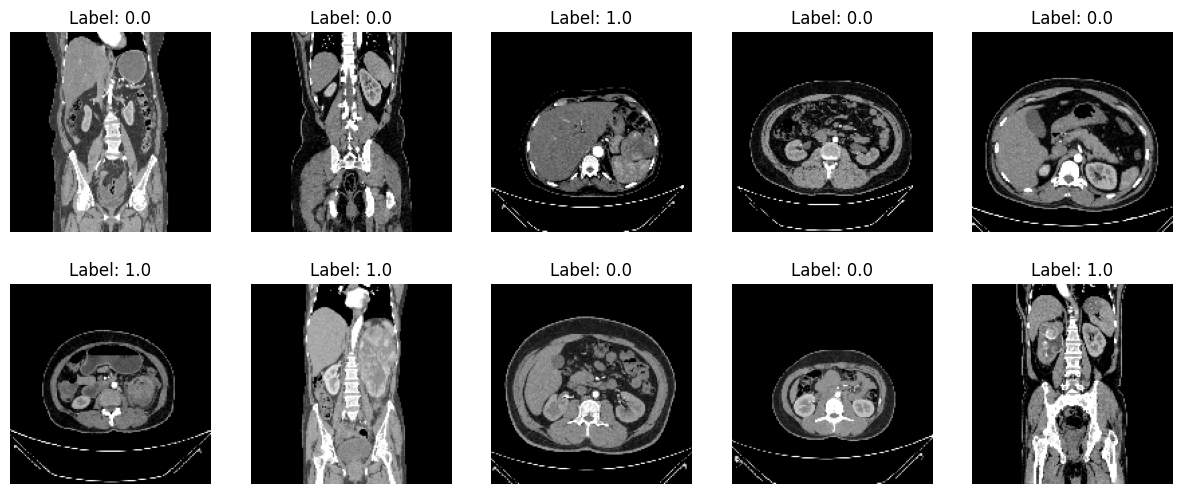

In [26]:

# Image Visualization
sample_images, sample_labels = train_generator.next()
sample_images = sample_images[:10]  # Select first 10 images
sample_labels = sample_labels[:10]  # Corresponding labels

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Label: {}'.format(sample_labels[i]))
    plt.axis('off')
plt.show()

In [28]:
import numpy as np
# Image Statistics
mean_pixel_intensity = np.mean(sample_images)
std_pixel_intensity = np.std(sample_images)

print('Mean Pixel Intensity:', mean_pixel_intensity)
print('Standard Deviation of Pixel Intensity:', std_pixel_intensity)

Mean Pixel Intensity: 0.1736676
Standard Deviation of Pixel Intensity: 0.26671478


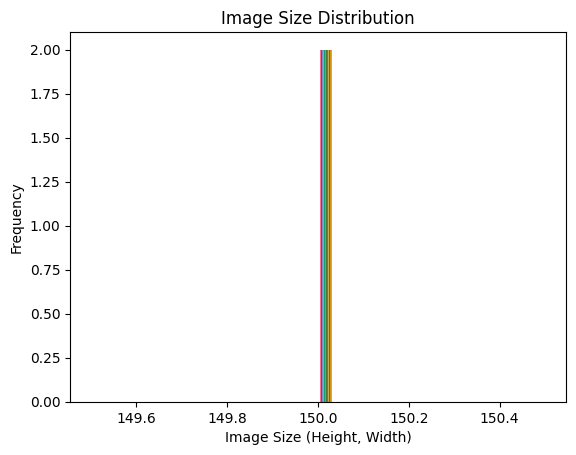

In [29]:
image_sizes = []
for i in range(len(train_generator)):
    batch_images, _ = train_generator[i]
    for image in batch_images:
        image_sizes.append(image.shape[:2])  # Keep only height and width

# Plot histogram of image sizes
plt.hist(image_sizes, bins=30)
plt.xlabel('Image Size (Height, Width)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()


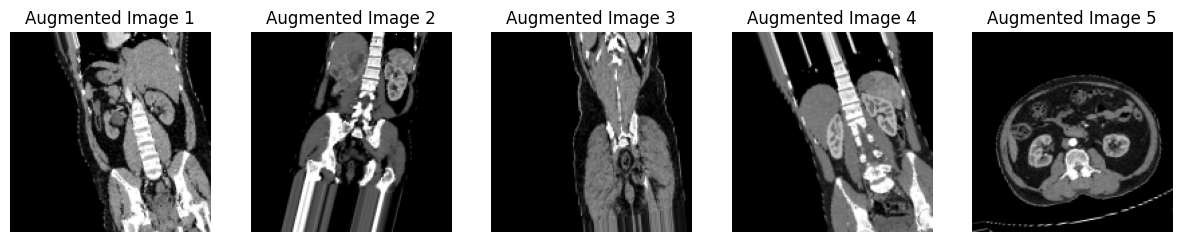

In [30]:
# Configure data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images, _ = next(data_augmentation.flow(train_generator.next(), batch_size=5))

# Plot augmented images
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title('Augmented Image {}'.format(i + 1))
    plt.axis('off')
plt.show()


In [15]:
# Define the CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [16]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
from keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [21]:
# Train the model with optimized parameters
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  # Start with a higher number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    batch_size=64,  # Increased batch size
    callbacks=[early_stopping]  # Early stopping
)

Epoch 1/20
185/185 [==============================] - 357s 2s/step - loss: 1.3994e-05 - accuracy: 1.0000 - val_loss: 1.4805 - val_accuracy: 0.8341
Epoch 2/20
185/185 [==============================] - 354s 2s/step - loss: 9.3464e-06 - accuracy: 1.0000 - val_loss: 1.5669 - val_accuracy: 0.8334
Epoch 3/20
185/185 [==============================] - 338s 2s/step - loss: 6.7352e-06 - accuracy: 1.0000 - val_loss: 1.5832 - val_accuracy: 0.8334
Epoch 4/20
185/185 [==============================] - 350s 2s/step - loss: 5.2364e-06 - accuracy: 1.0000 - val_loss: 1.6403 - val_accuracy: 0.8328


In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

230/230 [==============================] - 142s 619ms/step - loss: 0.2959 - accuracy: 0.9668
Test accuracy: 0.966847836971283


In [31]:
# Convert decimal accuracy to percentage
accuracy_percentage = test_acc * 100

# Print the accuracy percentage
print('Test accuracy:', accuracy_percentage, '%')


Test accuracy: 96.6847836971283 %


In [32]:
from keras.models import load_model

# Assuming 'model' is your trained model object
# Replace 'model' with the variable name of your trained model
# Replace 'kidney_model.h5' with the desired filename for your model
model.save('kidney_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
